# Reservoirs parameters - EFAS6
***

**Author:** Chus Casado Rodríguez<br>
**Date:** 04-03-2025<br>

1. [Climatic indices](#Climatic-indices)
2. [Reservoir/dam characteristics](#Reservoir/dam-characteristics)
3. [Water usage](#Water-usage)

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
import geopandas as gpd
from shapely.geometry import Point
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from pathlib import Path
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
from datetime import datetime

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# from lisfloodreservoirs.utils.plots import plot_reservoir_map
from lisfloodreservoirs.utils.plots import plot_attributes
from lisfloodreservoirs.utils.utils import duration_precip_indices

## Configuration

In [2]:
# paths
PATH_EFAS = Path('Z:/nahaUsers/casadje/EFASv6')
PATH_GDW = Path('Z:/nahaUsers/casadje/datasets/reservoirs/GDW/GDW_v1_0_shp')
PATH_GRAND = Path('Z:/nahaUsers/casadje/datasets/reservoirs/GRanD/v1_3')

PATH_OUT = PATH_EFAS / 'reservoirs' / 'tables' / 'attributes'
PATH_PLOTS = PATH_OUT / 'plots'
PATH_PLOTS.mkdir(exist_ok=True)

## DATA

### EFAS6

In [3]:
idx_name = 'GDW_ID'

# read table of reservoirs
res_file = list(PATH_OUT.parent.glob('efas6_reservoirs*.xlsx'))[-1]
print(f'Reservoir file: {res_file}')
reservoirs = pd.concat([pd.read_excel(res_file, sheet_name=sheet, index_col=idx_name) for sheet in ['as_reservoirs', 'as_lakes']], axis=0).sort_index()
# reservoirs = pd.read_excel(res_file, sheet_name='as_reservoirs', index_col=idx_name)
reservoirs = reservoirs.loc[reservoirs.index.notnull()]
reservoirs.index = reservoirs.index.astype(int)

# convert to geopandas
reservoirs = gpd.GeoDataFrame(
    data=reservoirs,
    geometry=[Point(xy) for xy in zip(reservoirs.LisfloodX, reservoirs.LisfloodY)],
    crs='epsg:4326'
)

print('{0} reservoirs'.format(len(reservoirs)))

Reservoir file: Z:\nahaUsers\casadje\EFASv6\reservoirs\tables\efas6_reservoirs_20250303.xlsx
1542 reservoirs


### GDW

In [4]:
# load dataset
gdw = gpd.read_file(PATH_GDW / 'GDW_barriers_v1_0.shp').set_index(idx_name)
gdw = gdw.loc[gdw.index.intersection(reservoirs.index)]
gdw.replace({0: np.nan, -99: np.nan}, inplace=True)

gdw.shape

(1534, 71)

### GRanD

In [5]:
# # load dataset
grand = gpd.read_file(PATH_GRAND / 'GRanD_dams_v1_3.shp')
grand.replace({-99: np.nan}, inplace=True)
grand = grand[grand.GRAND_ID.isin(reservoirs.GRAND_ID)]
map_grand_idx = {grand_id: idx for idx, grand_id in reservoirs.GRAND_ID.items() if not pd.isnull(grand_id)}
grand[idx_name] = grand.GRAND_ID.map(map_grand_idx)
grand.set_index(idx_name, drop=True, inplace=True)

grand.shape

(1521, 59)

## Climatic indices

* [x] temp_mean
* [x] pet_mean
* [x] precip_mean
* [x] snow_mean
* [x] aridity
* [x] seasonality
* [x] high_precip_freq
* [x] high_precip_dur
* [x] low_precip_freq
* [x] low_precip_dur

### Load time series

In [6]:
variables = {
    'ta': 'temp', # temperature
    'e0': 'pet', # potential evapotranspiration
    'pr': 'precip' # precipitation
}

***

In [ ]:
# # load outlets of `cutmaps`
# PATH_CUTMAPS = PATH_EFAS / 'reservoirs' / 'ancillary' / 'cutmaps'
# outlets = pd.read_csv(PATH_CUTMAPS / 'reservoirs.txt', sep='\t', header=None)
# outlets.columns = ['lon', 'lat', 'ID']
# outlets.set_index('ID', drop=True, inplace=True)

# # map ID in `cutmaps` and index in EFAS6
# map_id_idx = {res_id: reservoirs[reservoirs.RES_ID == res_id].index.item() for res_id in outlets.index.intersection(reservoirs.RES_ID)}
# atol = 8.333e-3
# for ID, coords in outlets.iterrows():
#     if ID in map_id_idx:
#         continue
#     mask = np.isclose(reservoirs.geometry.x, coords.lon, atol=atol) & np.isclose(reservoirs.geometry.y, coords.lat, atol=atol)
#     if mask.any():
#         map_id_idx[ID] = reservoirs[mask].index.item()
#     else:
#         print(ID)
# if len(map_id_idx) != len(outlets):
#     print('WARNING. The corresponding GDW_ID could not be found for all the outlets')

In [ ]:
# # rename catchstats files from ID to GDW_ID
# PATH_CATCHSTATS = path = PATH_EFAS / 'reservoirs' / 'ancillary' / 'catchstats'
# for var in variables:
#     print(var)
#     for input_file in (PATH_CATCHSTATS / var / 'ID').glob('*.nc'):
#         ID = int(input_file.stem)
#         if ID in map_id_idx:
#             idx = map_id_idx[ID]
#             output_file = input_file.parent.parent / idx_name / f'{idx}.nc'
#             if output_file.is_file():
#                 continue
#             ds = xr.open_dataset(input_file)
#             ds.close()
#             # ds = ds.rename({'id': 'GDW_ID'})
#             ds['id'] = [idx]
#             ds.to_netcdf(output_file)

In [ ]:
# gdw_ids = reservoirs.index.difference(map_id_idx.values())
# txt = pd.concat((reservoirs.loc[gdw_ids].geometry.x, reservoirs.loc[gdw_ids].geometry.y), axis=1)
# txt.columns = ['lon', 'lat']
# txt = txt.reset_index()
# txt[['lon', 'lat', idx_name]].to_csv(PATH_CUTMAPS / 'reservoirs_efas6_gdw_as_lakes.txt', sep='\t', header=None, index=None)

***

In [8]:
# load areal meteorological time series
path_meteo = PATH_EFAS / 'reservoirs' / 'ancillary' / 'catchstats'
meteo = xr.Dataset({
    name: xr.open_mfdataset((path_meteo / var / idx_name).glob('*.nc'), engine='netcdf4')[f'{var}_mean'].compute() for var, name in variables.items()
})

# compute precipitation as snowfall
meteo['snow'] = meteo['precip'].where(meteo['temp'] > 1, 0)

In [9]:
meteo

<xarray.Dataset>
Dimensions:  (time: 12053, id: 1358)
Coordinates:
  * time     (time) datetime64[ns] 1990-01-02T06:00:00 ... 2023-01-01T06:00:00
  * id       (id) int64 33 35 36 37 39 41 ... 50003 99994 99995 99997 99998
Data variables:
    temp     (time, id) float64 -6.928 -6.65 -5.409 -6.804 ... 14.2 13.21 11.16
    pet      (time, id) float64 0.1862 0.008617 0.08285 ... 0.7358 0.7512 0.4521
    precip   (time, id) float64 0.3285 0.002646 0.2016 ... 0.0 0.0 0.01101
    snow     (time, id) float64 0.0 0.0 0.0 0.0 0.0 ... 0.8738 0.0 0.0 0.01101

### Attributes

In [29]:
# average of all meteo variables
attrs_meteo = meteo.mean('time').to_pandas()
attrs_meteo.columns = [f'{col}_mean' for col in attrs_meteo.columns]
attrs_meteo.index.name = idx_name

# indices
attrs_meteo['aridity'] = attrs_meteo.precip_mean / attrs_meteo.pet_mean
attrs_meteo['frac_snow'] = attrs_meteo.snow_mean / attrs_meteo.precip_mean
attrs_meteo['moisture_index'] = attrs_meteo.precip_mean - attrs_meteo.pet_mean
precip_monthly = meteo['precip'].resample({'time': '1M'}).sum().groupby('time.month').mean()
precip_annual = meteo['precip'].resample({'time': 'A'}).sum().mean('time')
attrs_meteo['seasonality'] = ((precip_monthly.max('month') - precip_monthly.min('month')) / precip_annual).to_pandas()

# high and dry precipitation indices
precip_extremes = {
    'high': 20, # mm
    'low': 1 # mm
}
for key, value in precip_extremes.items():
    if key == 'high':
        mask_precip = meteo['precip'] > value
    elif key == 'low':
        mask_precip = meteo['precip'] < value
    attrs_meteo[f'{key}_precip_freq'] = mask_precip.sum('time') / len(meteo.time)
    attrs_meteo[f'{key}_precip_dur'] = duration_precip_indices(mask_precip.to_pandas())

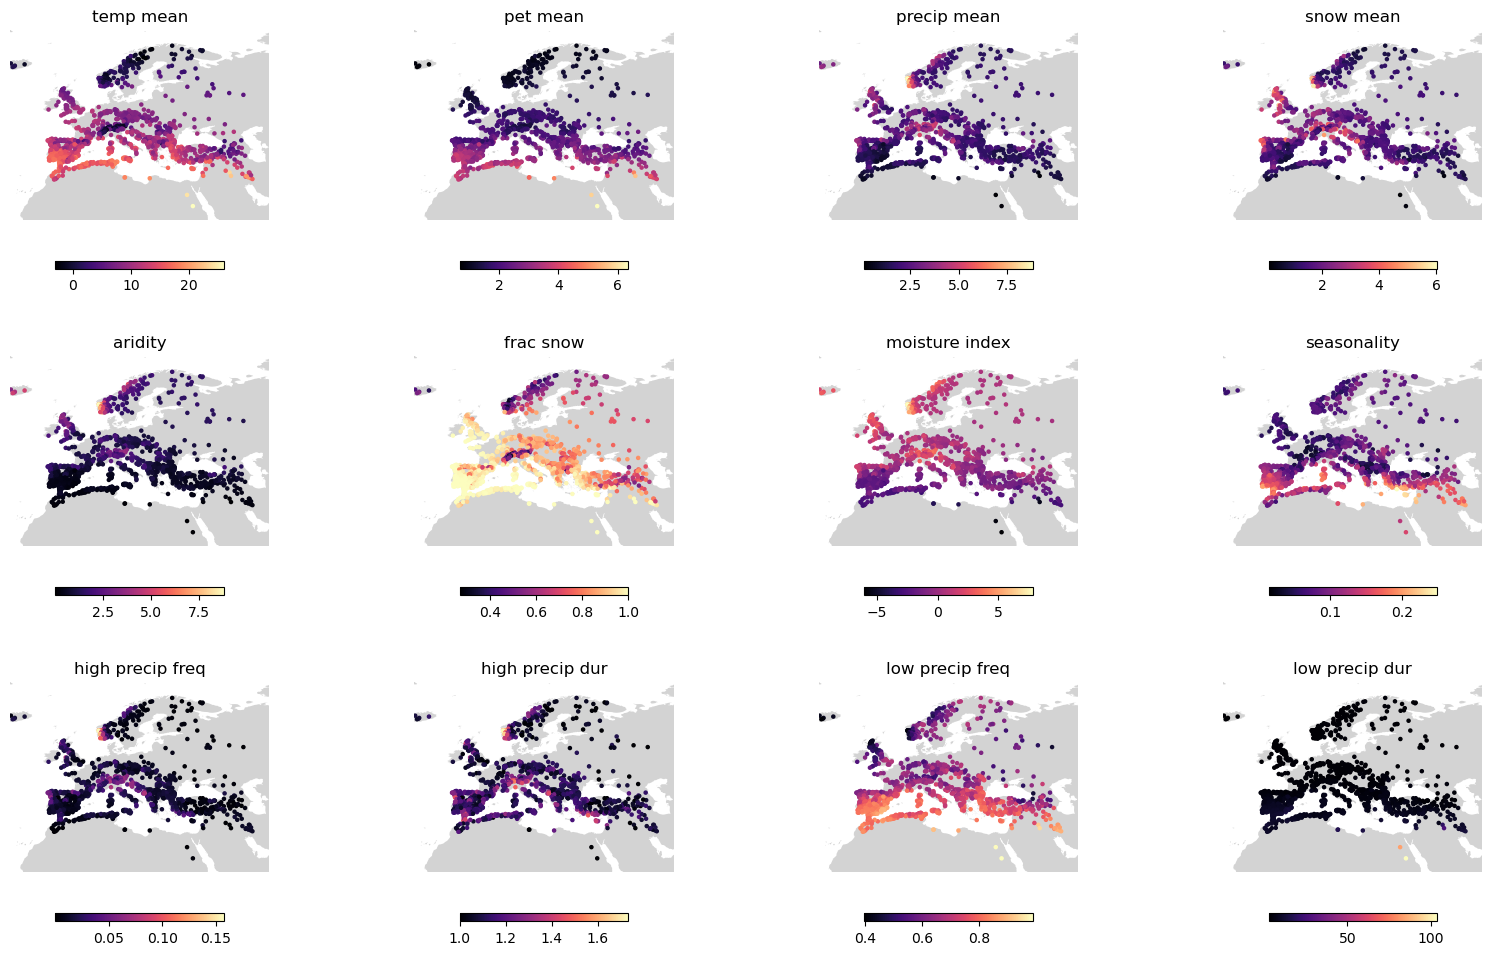

In [30]:
# plot attributes
r = 5
extent = [np.floor(reservoirs.geometry.x.min() / r) * r, np.ceil(reservoirs.geometry.x.max() / r) * r,
          np.floor(reservoirs.geometry.y.min() / r) * r, np.ceil(reservoirs.geometry.y.max() / r) * r]
# extent = [-180, 180, -90, 90]
plot_attributes(
    attrs_meteo,
    reservoirs.geometry.x,
    reservoirs.geometry.y,
    ncols=4,
    extent=extent,
    save=PATH_PLOTS / f'maps_climate.jpg'
)

In [31]:
attrs_meteo.shape

(1358, 12)

In [32]:
attrs_meteo.isnull().sum()

temp_mean           0
pet_mean            0
precip_mean         0
snow_mean           0
aridity             0
frac_snow           0
moisture_index      0
seasonality         0
high_precip_freq    0
high_precip_dur     0
low_precip_freq     0
low_precip_dur      0
dtype: int64

In [33]:
# export
attrs_meteo.to_csv(PATH_OUT / 'climatic_indices.csv')

## Reservoir/dam characteristics

* [x] cap_mcm
* [x] dam_hgt_m
* [x] dam_len_m
* [x] depth_m
* [x] dor_y
* [x] dod_m

`cap_mcm`, `dor_y` and `dod_m` can be extracted from the attributes in `reservoirs`.
The other attributes must be extracted from GRanD or GDW.

In [16]:
# attributes from EFAS tables
attrs_res = reservoirs[['CAP_MCM']].copy()
attrs_res['DOR_Y'] = reservoirs.DOR * 365
attrs_res['DOD_M'] = reservoirs.CAP_MCM / reservoirs.CATCH_SKM

# attributes from GDW
cols = ['DAM_HGT_M', 'DAM_LEN_M', 'DEPTH_M']
attrs_res.loc[gdw.index, cols] = gdw[cols].values
attrs_res.columns = attrs_res.columns.str.lower()

In [18]:
attrs_res.isnull().sum()

cap_mcm        0
dor_y          0
dod_m          0
dam_hgt_m    104
dam_len_m    254
depth_m       15
dtype: int64

In [19]:
attrs_res.shape

(1542, 6)

In [20]:
# export
attrs_res.to_csv(PATH_OUT / 'reservoir_characteristics.csv')

## Water usage

* [x] flood
* [x] fish
* [x] hydropower
* [x] irrigation
* [x] livestock
* [x] navigation
* [x] other
* [x] pollution
* [x] recreation
* [x] supply
* [x] main use
* [x] single use

In [21]:
rename_uses = {
    'USE_IRRI': 'irrigation',
    'USE_ELEC': 'hydropower',
    'USE_SUPP': 'supply',
    'USE_FCON': 'flood',
    'USE_RECR': 'recreation',
    'USE_NAVI': 'navigation',
    'USE_FISH': 'fish',
    'USE_PCON': 'pollution',
    'USE_LIVE': 'livestock',
    'USE_OTHR': 'other'
}

rename_main_use = {
    'Irrigation': 'irrigation',
    'Hydroelectricity': 'hydropower',
    'Water supply': 'supply',
    'Flood control': 'flood',
    'Recreation': 'recreation',
    'Navigation': 'navigation',
    'Other': 'other',   
    'Multipurpose': 'other'
}

# extract attributes
cols = list(rename_uses.keys()) + ['MAIN_USE']
attrs_use = gdw[list(rename_uses.keys()) + ['MAIN_USE']].copy()

# rename uses and convert them to 0 or 1
attrs_use.rename(columns=rename_uses, inplace=True)
uses = list(rename_uses.values())
attrs_use[uses] = attrs_use[uses].replace({'Main': True, 'Major': True, 'Sec': True, 'Multi': True, None: False}).astype(int)

# main use
attrs_use.MAIN_USE.replace(rename_main_use, inplace=True)

# identify single purpose reservoirs
attrs_use['SINGLE_USE'] = 0
mask_singleuse = attrs_use[uses].sum(axis=1) == 1
attrs_use.loc[mask_singleuse, 'SINGLE_USE'] = 1

In [22]:
attrs_use.isnull().sum()

irrigation      0
hydropower      0
supply          0
flood           0
recreation      0
navigation      0
fish            0
pollution       0
livestock       0
other           0
MAIN_USE      170
SINGLE_USE      0
dtype: int64

In [23]:
attrs_use.shape

(1534, 12)

In [24]:
# export
attrs_use.to_csv(PATH_OUT / 'reservoir_use.csv')